In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import numba
from numba import prange
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
plt.style.use("style1.mplstyle")

# Birth Death System

In [3]:
main_folder = "generated_data/birth_death/"

## Comp b/w standard and non-standard case

In [4]:
fname = "generated_data/birth_death/bd-abs_x2.npz"
data = np.load(fname)
print(data['desc'])
print(data.files)
print(data['metadata'])

Response of x2 to del_b in absorbing linear BD
['time_th', 'resp_th', 'time_sim', 'resp_sim', 'metadata', 'desc', 'col_desc', 'misc_dets']
[['b' '0.4']
 ['d' '0.5']
 ['del_b' '0.04000000000000001']
 ['ntrials' '1675163']]


In [5]:
del_b = 0.04

In [6]:
time_th = data['time_th']
resp_th = data['resp_th']
time_sim = data['time_sim']
resp_sim = data['resp_sim']

In [7]:
r_first_term = np.loadtxt(main_folder+"mean_and_variance/first_term.txt")
r_second_term = np.loadtxt(main_folder+"mean_and_variance/second_term.txt")

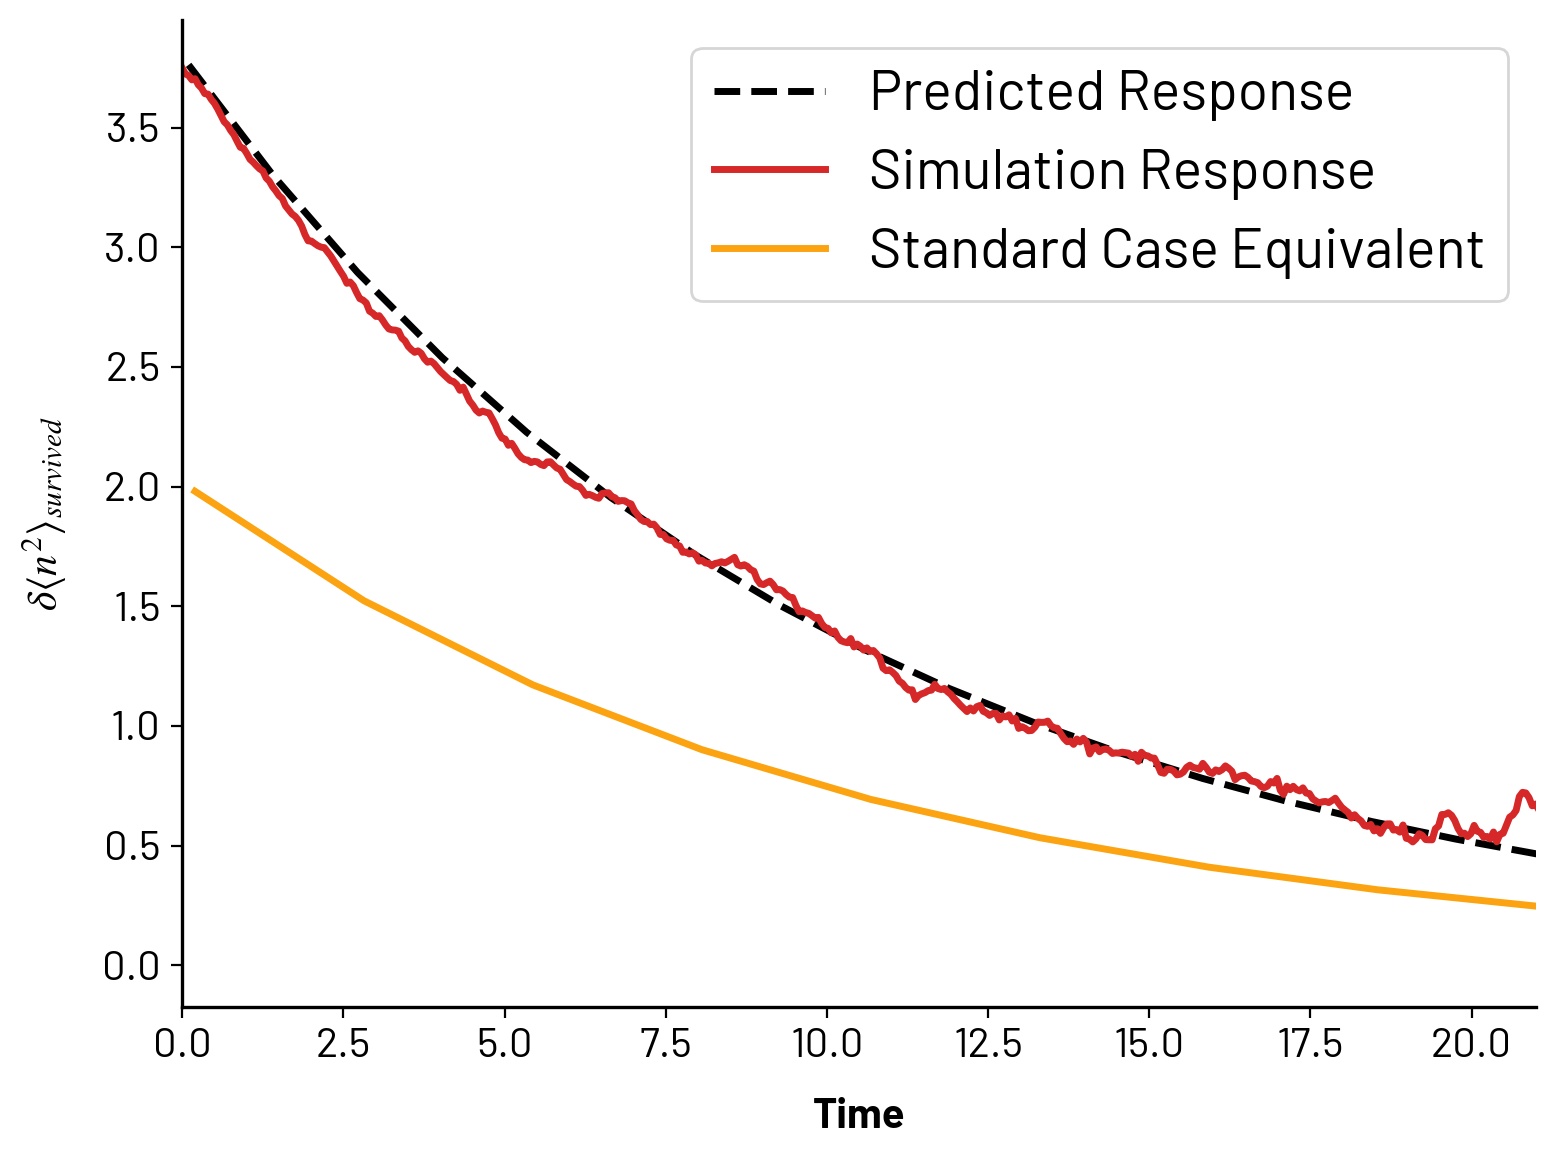

In [8]:
fig,ax = plt.subplots(figsize=(8,6),dpi=200)

plt.plot(time_th,resp_th,label="Predicted Response",linewidth=2.5,linestyle="dashed",color="black")
plt.plot(time_sim,resp_sim,label="Simulation Response",color="#d62828",linewidth=2.5)
plt.plot(time_th*2,r_first_term*del_b,label="Standard Case Equivalent",linewidth=2.5,color="#fca311")

plt.xlim(-0.01,21)
plt.legend(fontsize=20)
plt.xlabel("Time",fontsize=15,labelpad=12)
plt.ylabel(r"$\delta \langle n^2 \rangle_{survived}$",fontsize=15,labelpad=12)
ax.tick_params(axis="x",labelsize=15)
ax.tick_params(axis="y",labelsize=15)
#plt.title("Birth Death Process")

#plt.savefig("birth-death-comparison.jpg",bbox_inches="tight")

#plt.savefig("images_paper/svg/bd_comp.svg",format="svg")
plt.show()

## Mean and variance with b and d

In [9]:
b = 0.4
d = 0.5

del_bb = b/10
del_dd = d/10

In [10]:
lt_state = np.load("generated_data/birth_death/quasi_st.npz")
lt_state = lt_state.f.arr_0
survived = lt_state[np.where(lt_state!=0)[0]]

In [11]:
t_avg = np.load(main_folder+"mean_and_variance/time.npy")

x_avg_b = np.load(main_folder+"mean_and_variance/x_avg_b.npy")
x_avg_d = np.load(main_folder+"mean_and_variance/x_avg_d.npy")
x2_avg_b = np.load(main_folder+"mean_and_variance/x2_avg_b.npy")
x2_avg_d = np.load(main_folder+"mean_and_variance/x2_avg_d.npy")

t_array = np.load(main_folder+"theoretical_response/time.npy")

r_xv = np.load(main_folder+"theoretical_response/resp_x.npy")
r_xv2 = np.load(main_folder+"theoretical_response/resp_x2.npy")

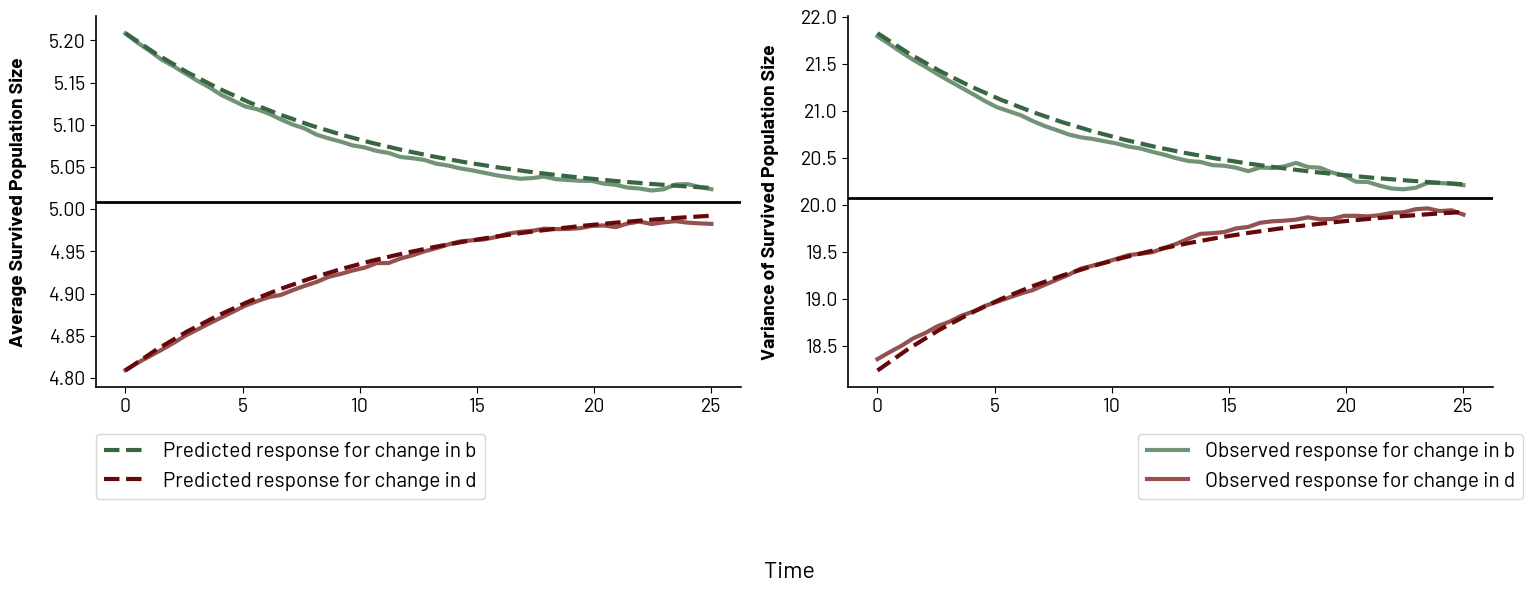

In [12]:
fig,ax = plt.subplots(1,2,figsize=(16,6))

ax[0].plot(t_avg,x_avg_b,color="#386641",linewidth=3,alpha=0.7)
ax[0].plot(t_avg,x_avg_d,color="#660708",linewidth=3,alpha=0.7)

ax[0].plot(t_array,r_xv*del_bb + np.mean(survived),color="#386641",linestyle="dashed",linewidth=3,label="Predicted response for change in b")
ax[0].plot(t_array,-r_xv*b/d*del_dd + np.mean(survived),color="#660708",linestyle="dashed",linewidth=3,label="Predicted response for change in d")

ax[0].axhline(np.mean(survived),linestyle="solid",color="black")
ax[0].set_ylabel(r"Average Survived Population Size")
ax[0].legend(fontsize=15,loc=(0.0,-0.3))


ax[1].plot(t_avg,(x2_avg_b - x_avg_b**2),color="#386641",linewidth=3,alpha=0.7,label="Observed response for change in b")
ax[1].plot(t_avg,(x2_avg_d - x_avg_d**2),color="#660708",linewidth=3,alpha=0.7,label="Observed response for change in d")

ax[1].plot(t_array,r_xv2*del_bb - (del_bb*r_xv)**2 - 2*(r_xv*np.mean(survived)*del_bb) +   (np.mean(survived**2) - np.mean(survived)**2)
            ,color="#386641",linestyle="dashed",linewidth=3)
ax[1].plot(t_array,-b/d*r_xv2*del_dd - (-b/d*del_dd*r_xv)**2 - 2*(-b/d*r_xv*np.mean(survived)*del_dd) +   (np.mean(survived**2) - np.mean(survived)**2)
            ,color="#660708",linestyle="dashed",linewidth=3)

ax[1].axhline((np.mean(survived**2) - np.mean(survived)**2),linestyle="solid",color="black")
ax[1].set_ylabel(r"Variance of Survived Population Size")
ax[1].legend(fontsize=15,loc=(0.45,-0.3))

fig.supxlabel("Time")

#plt.savefig("images_paper/svg/mean_variance.svg",format="svg")

plt.show()


## Survival probability with deforestation

In [13]:
b = 0.4
d = 0.5

tp = 1
Tr = 5

In [14]:
lt_state = np.load("generated_data/birth_death/quasi_st.npz")
lt_state = lt_state.f.arr_0
survived = lt_state[np.where(lt_state!=0)[0]]

In [15]:
t_avg = np.load(main_folder+"survival_prob/time.npy")

def_d = np.load(main_folder+"survival_prob/d_pert.npy")
def_b = np.load(main_folder+"survival_prob/b_pert.npy")

r_surv = np.load(main_folder+"theoretical_response/resp_surv.npy")

t_array = np.load(main_folder+"theoretical_response/time.npy")

avg_counter_def = np.load(main_folder+"survival_prob/avg_counter.npy")

x_avg_def = np.load(main_folder+"survival_prob/x_avg.npy")
x2_avg_def = np.load(main_folder+"survival_prob/x2_avg.npy")

In [16]:
def respIntegrate(respFunc,perturbation,tpoints):
    dobs = np.zeros(tpoints.size)
    for ti in range(tpoints.size):
        t = tpoints[ti]
        integration = 0
        for taui in range(ti):
            tau = tpoints[taui]
            dtau = tpoints[taui+1] - tpoints[taui]
            integration += respFunc[ti-taui] * perturbation[taui] * dtau
        dobs[ti] = integration
    return dobs

In [17]:
interpfn_surv = interp1d(t_array,r_surv,kind="cubic")
interp_resp_surv = interpfn_surv(t_avg)

conv_def_b = respIntegrate(interp_resp_surv,def_b,t_avg)
conv_def_d = respIntegrate(-b/d*(interp_resp_surv+1)+1,def_d,t_avg)

In [18]:
interpfn_rxv = interp1d(t_array,r_xv,kind="cubic")
interpfn_rxv2 = interp1d(t_array,r_xv2,kind="cubic")

interp_resp_x = interpfn_rxv(t_avg)
interp_resp_x2 = interpfn_rxv2(t_avg)


resp_xb = respIntegrate(interp_resp_x,def_b,t_avg)
resp_x2b = respIntegrate(interp_resp_x2,def_b,t_avg)


resp_xd = respIntegrate(-b/d*interp_resp_x,def_d,t_avg)
resp_x2d = respIntegrate(-b/d*interp_resp_x2,def_d,t_avg)

/home/prajwal/miniconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


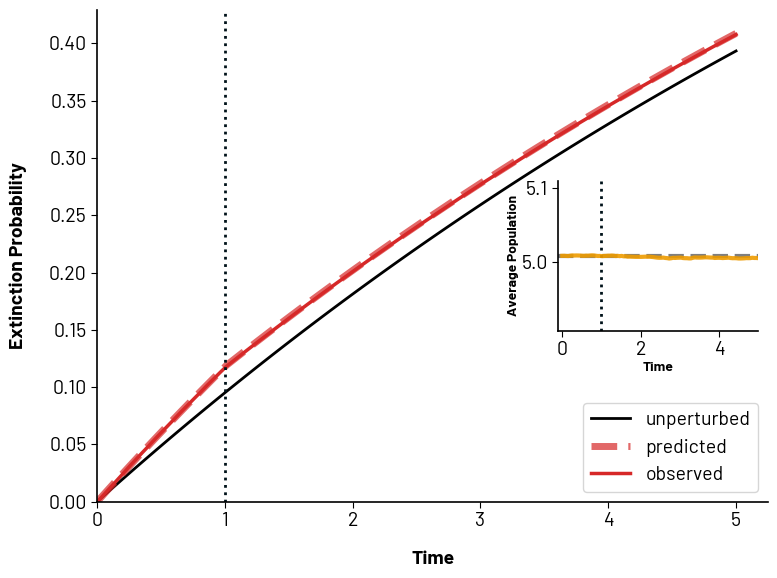

In [44]:
fig,ax = plt.subplots(figsize=(8,6))

axins = inset_axes(ax, width=2, height=1.5,loc=7)


#ax[0].plot(t_array,r_xv*del_bdef - r_xv*b/d*del_ddef + np.mean(survived))
axins.axvline(tp,linestyle='dotted')
axins.axhline(np.mean(survived),linestyle="dashed",color="black",linewidth=3,alpha=0.5)
axins.plot(t_avg,x_avg_def,color="#ee9b00",linewidth=3,alpha=0.9)

axins.set_xlim(-0.1,Tr)
axins.set_ylim(np.mean(survived)*0.98,np.mean(survived)*1.02)
axins.set_xlabel("Time",fontsize=10,labelpad=2)
axins.set_ylabel("Average Population",fontsize=10,labelpad=2)

ax.plot(t_avg,1-np.exp(-(d-b)*t_avg),label="unperturbed",color="black",linestyle="solid")
ax.plot(t_avg,1-((1-conv_def_d -conv_def_b)*np.exp(-(d-b)*t_avg)),color="#d62828",label="predicted",linestyle="dashed",linewidth=5,alpha=0.7)
ax.plot(t_avg,1-(avg_counter_def/avg_counter_def[0]),color="#d62828",label="observed",linewidth=2.5)

ax.axvline(tp,linestyle='dotted')
ax.set_xlabel("Time")
ax.set_ylabel("Extinction Probability")
ax.set_xlim(0,)
ax.set_ylim(0,)
ax.legend()

#plt.savefig("images_paper/svg/surv_prob.svg",format="svg")


plt.show()

# DNA Target search

In [3]:
folder = "generated_data/dna_search/"

In [4]:
L = 100
kon = 0.5
koff = 1
u = 2

target = 60

In [5]:
@numba.njit(parallel=True)
def respIntegrate(respFunc,perturbation,tpoints):
    dobs = np.zeros(tpoints.size)
    for ti in prange(tpoints.size):
        t = tpoints[ti]
        integration = 0
        for taui in range(ti):
            tau = tpoints[taui]
            dtau = tpoints[taui+1] - tpoints[taui]
            integration += respFunc[ti-taui] * perturbation[taui] * dtau
        dobs[ti] = integration
    return dobs

In [6]:
temp = respIntegrate(np.ones(3),np.ones(3),np.ones(3))

## Temperature change

In [7]:
dist_avg = 998.181052229281

In [8]:
pertTracks_orig = np.load(folder+"temp_perturbation/perturbedTracks.npz")
pertTracks_orig = pertTracks_orig.f.arr_0

In [9]:
randIndices = np.random.choice(np.arange(0,pertTracks_orig.shape[0],1,dtype=int),size=int(1e5))
pertTracks_temp = pertTracks_orig

print(pertTracks_orig.shape[0]/len(randIndices))

118.9276


In [10]:
removedpt_orig = np.load(folder+"quasi_st_dist.npy")
removedpt = removedpt_orig

In [11]:
tpoints = np.load(folder+"temp_perturbation/time_observation.npy")
tintegrate = np.load(folder+"temp_perturbation/time_perturbation.npy")

ttheoryjdist = np.load(folder+"theory_resp_fn/time.npy")
respFuncu_dist = np.load(folder+"theory_resp_fn/dist/dist_resp_u.npy")
respFunckon_dist = np.load(folder+"theory_resp_fn/dist/dist_resp_kon.npy")
respFunckoff_dist = np.load(folder+"theory_resp_fn/dist/dist_resp_koff.npy")

In [12]:
deltemp_u = np.load(folder+"temp_perturbation/delu.npy")
deltemp_kon = np.load(folder+"temp_perturbation/delkon.npy")
deltemp_koff = np.load(folder+"temp_perturbation/delkoff.npy")

In [13]:
interp_fnu_dist = interp1d(ttheoryjdist,respFuncu_dist,kind="cubic")
interp_fnkon_dist = interp1d(ttheoryjdist,respFunckon_dist,kind="cubic")
interp_fnkoff_dist = interp1d(ttheoryjdist,respFunckoff_dist,kind="cubic")

interp_respu_dist = interp_fnu_dist(tintegrate)
interp_respkon_dist = interp_fnkon_dist(tintegrate)
interp_respkoff_dist = interp_fnkoff_dist(tintegrate)

In [14]:
# avg dist

avg_dist_surv_temp = np.zeros(tpoints.size)

for ti in range(tpoints.size):
    survpositions = np.where(pertTracks_temp[:,ti]!=target)[0]
    avg_dist_surv_temp[ti] = np.mean((pertTracks_temp[:,ti][survpositions] - target)**2)# - (removedpt[:pertTracks_temp.shape[0]][survpositions] - target)**2)

In [15]:
dobs_u_dist_temp = respIntegrate(interp_respu_dist,deltemp_u,tintegrate)
dobs_kon_dist_temp = respIntegrate(interp_respkon_dist,deltemp_kon,tintegrate)
dobs_koff_dist_temp = respIntegrate(interp_respkoff_dist,deltemp_koff,tintegrate)

In [16]:
unew_t = u + deltemp_u
konnew_t = kon + deltemp_kon
koffnew_t = koff + deltemp_koff

In [17]:
#correcting for finite number of trajectories causing offset in initial distribution

offset = np.sqrt((np.mean((removedpt[:pertTracks_temp.shape[0]][np.where(pertTracks_temp[:,0]!=target)[0]]-target)**2))) - np.sqrt((dist_avg))

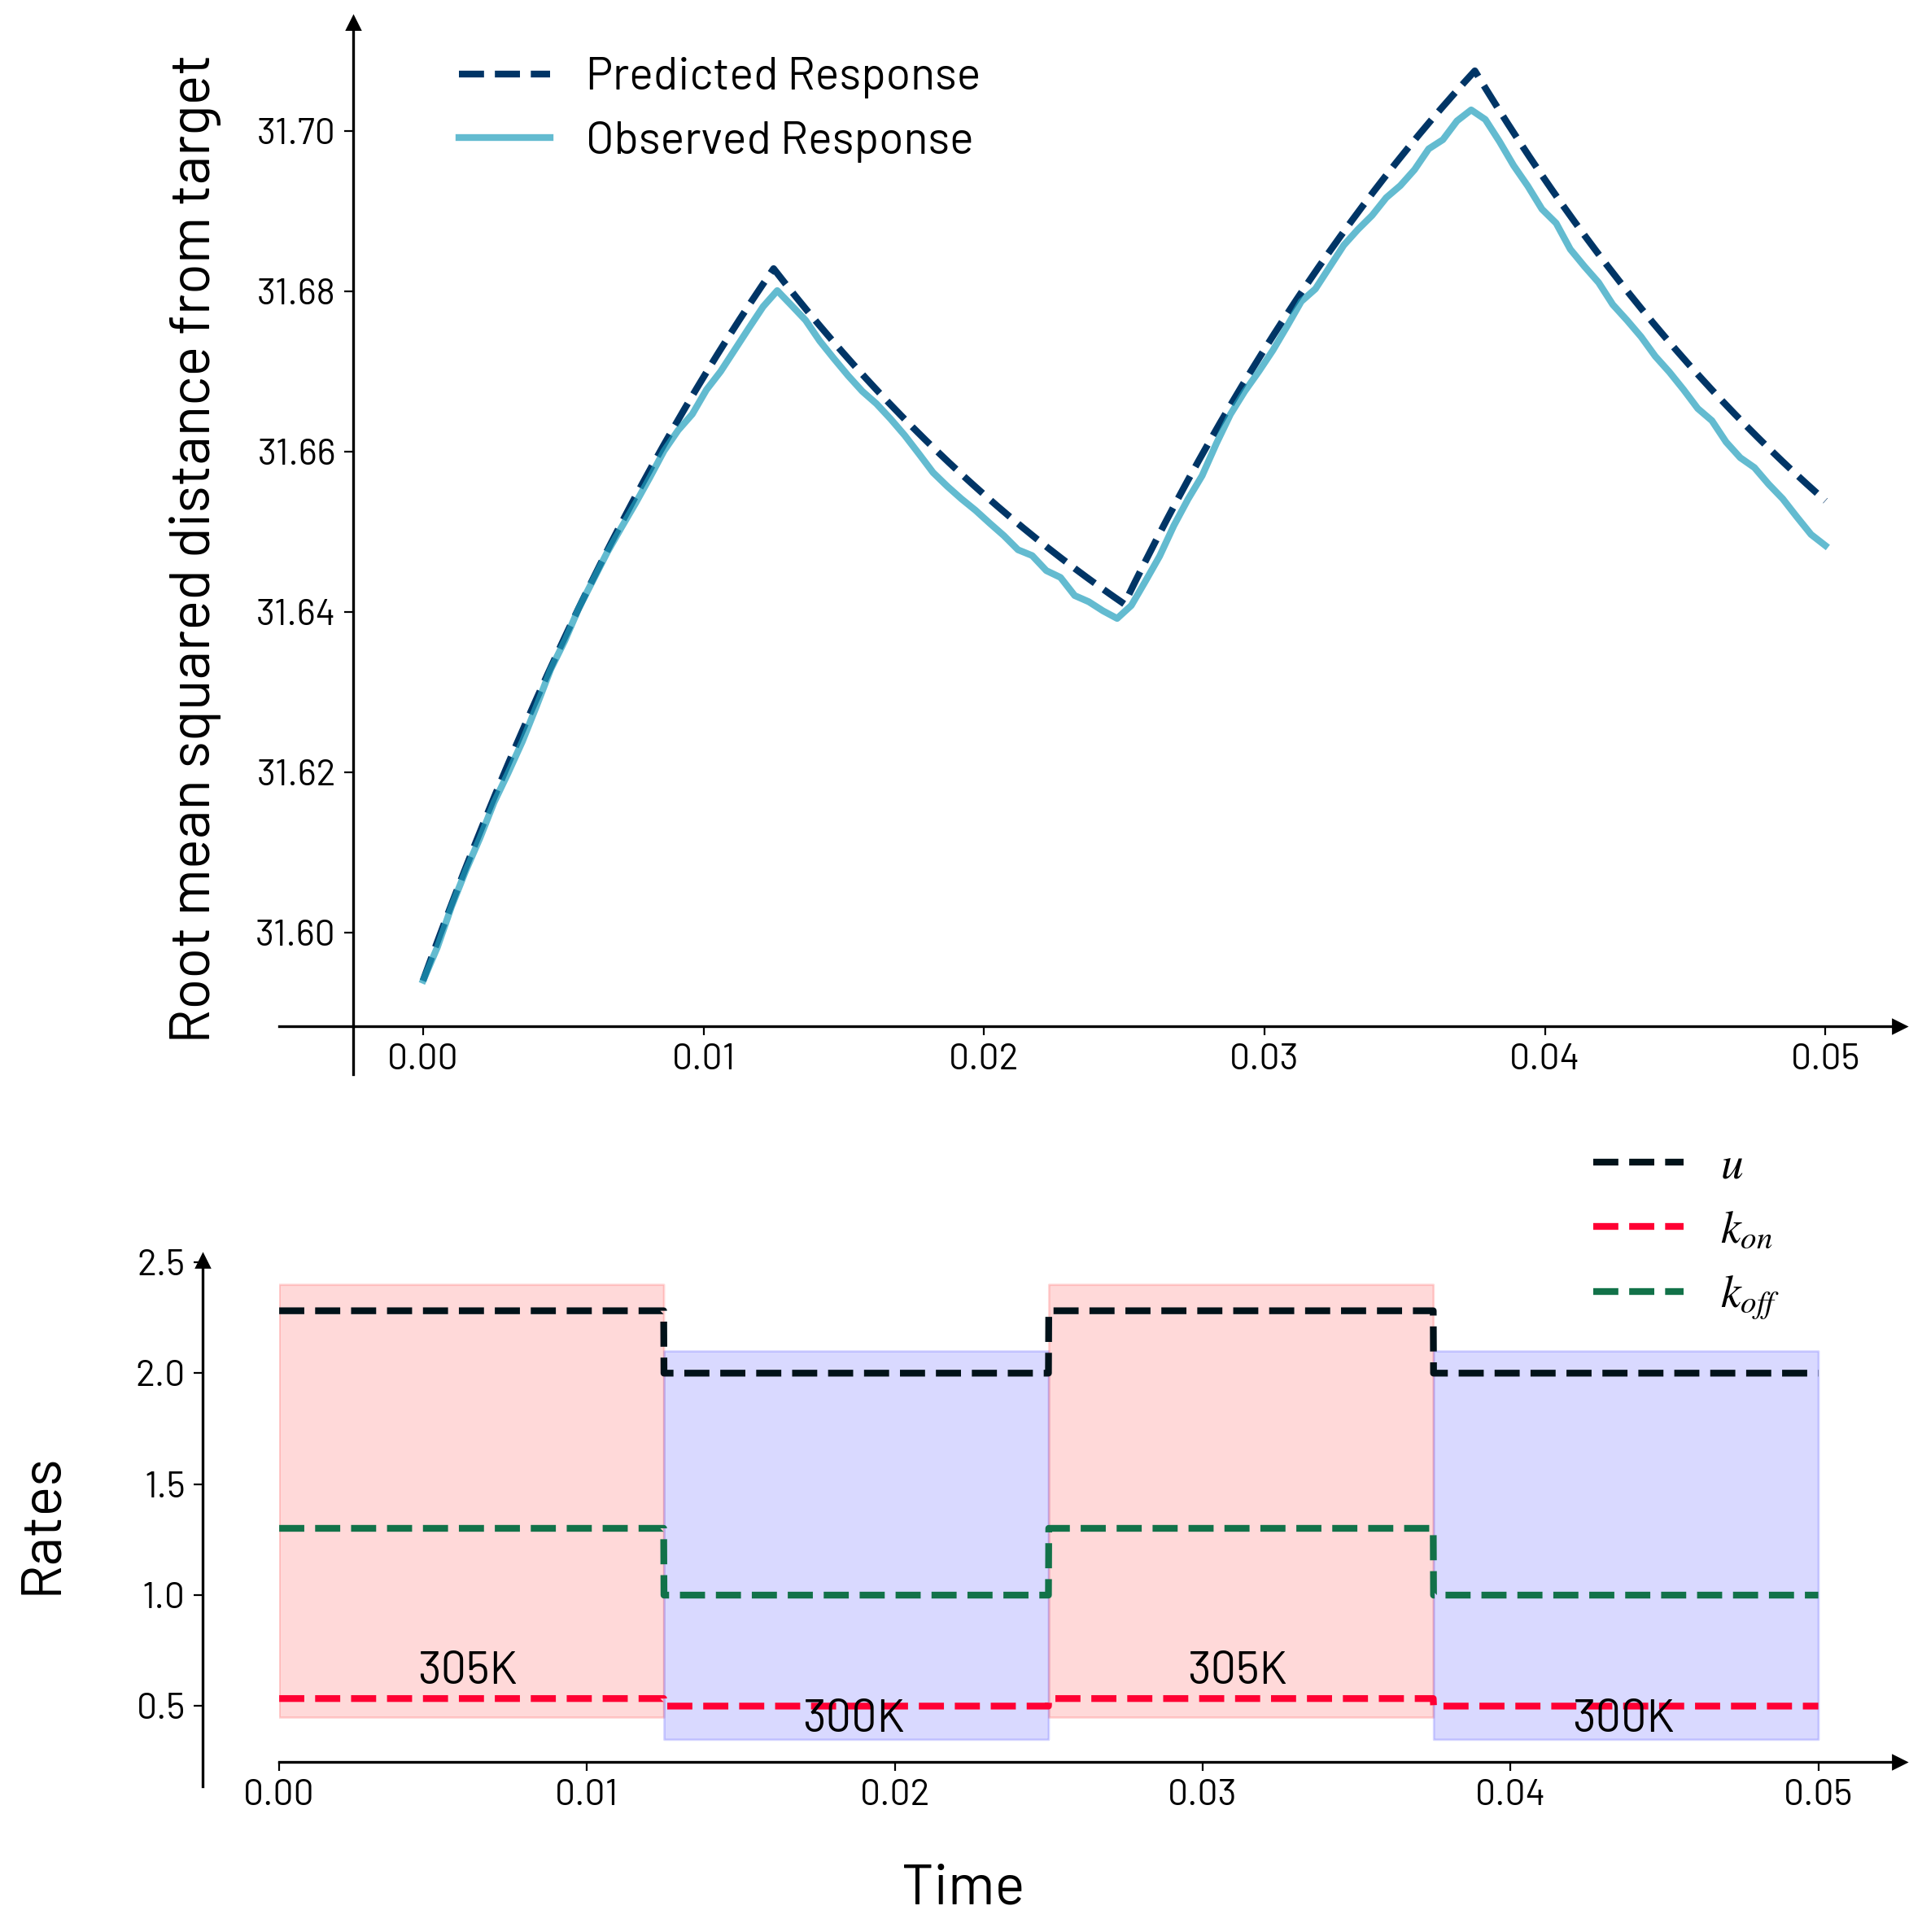

In [19]:
fig,ax = plt.subplots(2,1,gridspec_kw={'height_ratios':[2,1]},figsize=(12,12),dpi=200)

#ax[0].set_xlim(0,)
ax[0].plot(tintegrate,np.sqrt((-dobs_u_dist_temp - dobs_kon_dist_temp - dobs_koff_dist_temp) + dist_avg),label="Predicted Response",linestyle="dashed",color="#003566",linewidth=3)
ax[0].plot(tpoints,np.sqrt(avg_dist_surv_temp) -offset,label="Observed Response",linewidth=3,alpha=0.7,color="#219ebc")

ax[0].set_ylabel("Root mean squared distance from target",weight="normal",fontsize=25)
ax[0].legend(fontsize=20,loc=(0.1,0.85),frameon=False)

ax0minx,ax0miny = ax[0].get_xlim()[0],ax[0].get_ylim()[0]
ax[0].spines["left"].set_position(("data", ax0minx))
ax[0].spines["bottom"].set_position(("data", ax0miny))
ax[0].plot(1, ax0miny, ">k", transform=ax[0].get_yaxis_transform(), clip_on=False)
ax[0].plot(ax0minx, 1, "^k", transform=ax[0].get_xaxis_transform(), clip_on=False)
ax[0].tick_params(axis='both', which='major', labelsize=16)


#ax[1].set_xlim(0,)
ax[1].plot(tintegrate,unew_t,linestyle="dashed",label=r"$u$",linewidth=3)
ax[1].plot(tintegrate,konnew_t,linestyle="dashed",label=r"$k_{on}$",color="#FF0033",linewidth=3)
ax[1].plot(tintegrate,koffnew_t,linestyle="dashed",label=r"$k_{off}$",color="#127249",linewidth=3)

ax[1].fill_between(tintegrate[:tintegrate.size//4],0.45,2.4,color="red",alpha=0.15)
ax[1].fill_between(tintegrate[tintegrate.size//4:tintegrate.size//2],0.35,2.1,color="blue",alpha=0.15)
ax[1].fill_between(tintegrate[tintegrate.size//2:3*tintegrate.size//4],0.45,2.4,color="red",alpha=0.15)
ax[1].fill_between(tintegrate[3*tintegrate.size//4:],0.35,2.1,color="blue",alpha=0.15)

ax[1].set_ylabel("Rates",weight="normal",fontsize=25,labelpad=30)
ax[1].legend(fontsize=20,loc=(0.8,0.85),frameon=False)

ax[1].text(0.0045,0.6,"305K",fontsize=20)
ax[1].text(0.017,0.385,"300K",fontsize=20)
ax[1].text(0.0295,0.6,"305K",fontsize=20)
ax[1].text(0.042,0.385,"300K",fontsize=20)

ax1minx,ax1miny = ax[1].get_xlim()[0],ax[1].get_ylim()[0]
ax[1].spines["left"].set_position(("data", ax1minx))
ax[1].spines["bottom"].set_position(("data", ax1miny))
ax[1].plot(1, ax1miny, ">k", transform=ax[1].get_yaxis_transform(), clip_on=False)
ax[1].plot(ax1minx, 1, "^k", transform=ax[1].get_xaxis_transform(), clip_on=False)
ax[1].tick_params(axis='both', which='major', labelsize=16)
ax[1].set_xlim(0,)
#ax[1].set_yscale('log')

fig.supxlabel("Time",weight="normal",fontsize=25)

#plt.savefig("dna_search_temperature.jpg")

#plt.savefig("images_paper/svg/temp_change.svg",format="svg")

plt.show()

## Controlling response

In [58]:
test_pert_orig = np.load(folder+"control/perturbedTracks.npz")
test_pert_orig = test_pert_orig.f.arr_0

In [59]:
randIndices = np.random.choice(np.arange(0,test_pert_orig.shape[0],1),size=int(1e6))
testpert = test_pert_orig

print(test_pert_orig.shape[0]/len(randIndices))

11.89276


In [60]:
removedpt_orig = np.load(folder+"quasi_st_dist.npy")
removedpt = removedpt_orig

In [61]:
tintegrate = np.load(folder+"control/time.npy")

tpoints = np.load(folder+"control/time_obs.npy")

desiredPerturbation = np.load(folder+"control/desired.npy")

In [62]:
# avg pos

avg_pos_surv_test = np.zeros(tpoints.size)

for ti in range(tpoints.size):
    survpositions_test = np.where(testpert[:,ti]!=target)[0]
    avg_pos_surv_test[ti] = np.mean(testpert[:,ti][survpositions_test] - removedpt[:testpert.shape[0]][survpositions_test])

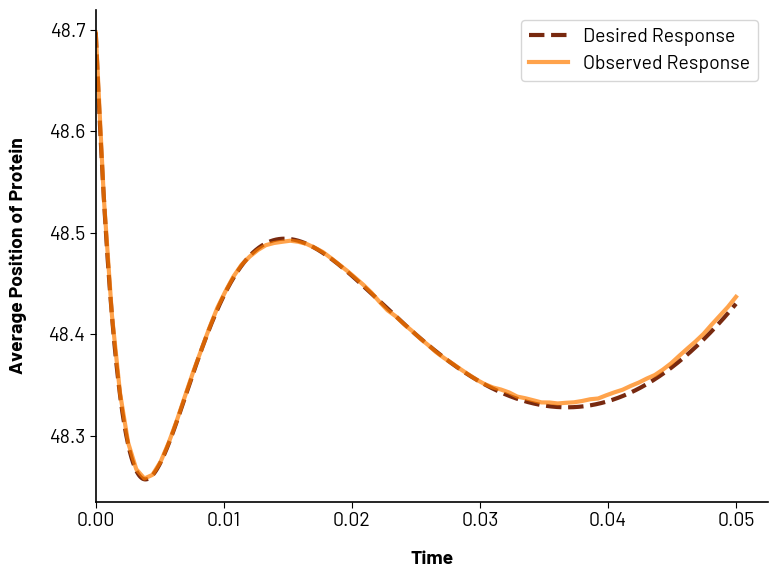

In [63]:
plt.plot(tintegrate,desiredPerturbation+np.mean(removedpt) ,label="Desired Response",linestyle="dashed",color="#78290f",linewidth=3)
plt.plot(tpoints,avg_pos_surv_test+np.mean(removedpt),label="Observed Response",color="#ff7d00",linewidth=3,alpha=0.7)

plt.xlabel("Time")
plt.ylabel("Average Position of Protein")

plt.xlim(0,)
plt.legend()

#plt.savefig("images_paper/temp/control.png")

#plt.savefig("images_paper/svg/control.svg",format="svg")

plt.show()